<a href="https://colab.research.google.com/github/fatuunreal/stki4/blob/main/stki4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!pip install ekphrasis

In [6]:
from ekphrasis.classes.preprocessor import TextPreProcessor
from ekphrasis.classes.tokenizer import SocialTokenizer
from ekphrasis.dicts.emoticons import emoticons

text_processor = TextPreProcessor(
    # terms that will be normalized
    normalize=['email', 'percent', 'money', 'phone', 'user',
        'time', 'date', 'number'],
    # terms that will be annotated
    #annotate={"hashtag", "allcaps", "elongated", "repeated",'emphasis', 'censored'},
    annotate={"hashtag","allcaps","elongated","repeated",'emphasis','censored'},
    fix_html=True,  # fix HTML tokens

    # corpus from which the word statistics are going to be used
    # for word segmentation
    segmenter="twitter",

    # corpus from which the word statistics are going to be used
    # for spell correction
    corrector="twitter",

    unpack_hashtags=True,  # perform word segmentation on hashtags
    unpack_contractions=True,  # Unpack contractions (can't -> can not)
    spell_correct_elong=False,  # spell correction for elongated words

    # select a tokenizer. You can use SocialTokenizer, or pass your own
    # the tokenizer, should take as input a string and return a list of tokens
    tokenizer=SocialTokenizer(lowercase=True).tokenize,

    # list of dictionaries, for replacing tokens extracted from the text,
    # with other expressions. You can pass more than one dictionaries.
    dicts=[emoticons]
)

Reading twitter - 1grams ...
Reading twitter - 2grams ...
Reading twitter - 1grams ...


**Load Library**

In [7]:
import re
import string
import pandas as pd
from copy import deepcopy

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

**Load Datasets**

In [127]:
df = pd.read_csv('tweet-jokowi.csv')

In [128]:
df.head()

,Unnamed: 0,text,Label
0,0,rt @megatop99: @conannkri @ccicpolri @mohmahfu...,positif
1,1,@jokowi harga2 pd naik gaji aparat negara gk n...,negatif
2,2,xx : kalian coba mengusir yang mau membersihka...,negatif
3,3,@jokowi haturnuhun bapak presiden @jokowi tela...,netral
4,4,@rifanrobani @catatan_ali7 @erickthohir @jokow...,netral


In [129]:
# Create a label encoding dictionary
label_encoding = {
    'positif': 2,
    'netral': 1,
    'negatif': 0
}

# Apply the encoding to the 'Label' column
df['Label'] = df['Label'].str.strip(';').map(label_encoding)

# Verify the encoding
print(df['Label'].value_counts())

Label
2.0    373
0.0    372
1.0    254
Name: count, dtype: int64


In [135]:
# Check for missing values in the 'Label' column
missing_labels = df['Label'].isnull().sum()
print(f"Number of missing values in 'Label' column: {missing_labels}")

# Remove rows with missing values in the 'Label' column
df = df.dropna(subset=['Label'])

# Verify the removal
missing_labels_after_removal = df['Label'].isnull().sum()
print(f"Number of missing values in 'Label' column after removal: {missing_labels_after_removal}")

Number of missing values in 'Label' column: 0
Number of missing values in 'Label' column after removal: 0


In [134]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 999 entries, 0 to 1005
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  999 non-null    int64  
 1   text        999 non-null    object 
 2   Label       999 non-null    float64
dtypes: float64(1), int64(1), object(1)
memory usage: 31.2+ KB


# Preprosesing

### setting fungsi

In [138]:
def bersih_data(text):
    return " ".join(text_processor.pre_process_doc(text))

def non_ascii(text):
    return text.encode('ascii', 'replace').decode('ascii')

def remove_space_alzami(text):
    return " ".join(text.split())

def remove_emoji_alzami(text):
    return ' '.join(re.sub("([x#][A-Za-z0-9]+)"," ", text).split())

def remove_tab(text):
    return text.replace('\\t'," ").replace('\\n'," ").replace('\\u'," ").replace('\\',"")

def remove_tab2(text):
    return re.sub('\s+',' ',text)

def remove_rt(text):
    return text.replace('RT'," ")

def remove_mention(text):
    return ' '.join(re.sub("([@#][A-Za-z0-9]+)|(\w+:\/\/\S+)"," ", text).split())

def remove_incomplete_url(text):
    return text.replace("http://", " ").replace("https://", " ")

def remove_single_char(text):
    return re.sub(r"\b[a-zA-Z]\b", "", text)

def change_stripe(text):
    return text.replace('-'," ")

def lower(text):
    return text.lower()

def remove_punctuation(text):
    remove = string.punctuation
    remove = remove.replace("_", "") # don't remove hyphens
    pattern = r"[{}]".format(remove) # create the pattern
    return re.sub(pattern, "", text)

## running preprosesing

In [139]:
final_string = []
for text in df['text'].values:
    EachReviewText = ""
    proc = bersih_data(text)
    proc = remove_rt(proc)
    proc = lower(proc)
    proc = change_stripe(proc)
    proc = remove_tab(proc)
    proc = remove_tab2(proc)
    proc = non_ascii(proc)
    proc = remove_incomplete_url(proc)
    proc = remove_single_char(proc)
    proc = remove_punctuation(proc)
    proc = remove_space_alzami(proc)
    EachReviewText = proc
    final_string.append(EachReviewText)

masukkan hasil preprocessing ke kolom step01

In [140]:
df["step01"] = final_string

In [141]:
df.head(14)

,Unnamed: 0,text,Label,step01
0,0,rt @megatop99: @conannkri @ccicpolri @mohmahfu...,2.0,rt user user user user negara demokrasi itu hu...
1,1,@jokowi harga2 pd naik gaji aparat negara gk n...,0.0,user harga2 pd naik gaji aparat negara gk naik...
2,2,xx : kalian coba mengusir yang mau membersihka...,0.0,xx kalian coba mengusir yang mau membersihkan ...
3,3,@jokowi haturnuhun bapak presiden @jokowi tela...,1.0,user haturnuhun bapak presiden user telah berk...
4,4,@rifanrobani @catatan_ali7 @erickthohir @jokow...,1.0,user user user user bahkan bisa jadi titisannya
5,5,rt @_delightbee: @jokowi @pertamina @kemenbumn...,2.0,rt user user user user kapan lagi ya pak rakya...
6,6,@jokowi @pertamina @kemenbumn kapan lagi ya pa...,2.0,user user user kapan lagi ya pak rakyat mu rin...
7,7,presiden @jokowi memberikan keterangan pers sa...,2.0,presiden user memberikan keterangan pers saat ...
8,8,rt @jokowi: saat dunia mengalami kekurangan pa...,2.0,rt user saat dunia mengalami kekurangan pangan...
9,9,rt @jokowi: situasi dunia sedang terdisrupsi d...,2.0,rt user situasi dunia sedang terdisrupsi di bi...


In [142]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 999 entries, 0 to 1005
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  999 non-null    int64  
 1   text        999 non-null    object 
 2   Label       999 non-null    float64
 3   step01      999 non-null    object 
dtypes: float64(1), int64(1), object(2)
memory usage: 39.0+ KB


hapus record yang kosong

In [143]:
df_hapus = df[~df['step01'].str.contains(" ")]

In [144]:
df_new = df[~df.isin(df_hapus)].dropna()

In [145]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 996 entries, 0 to 1005
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  996 non-null    float64
 1   text        996 non-null    object 
 2   Label       996 non-null    float64
 3   step01      996 non-null    object 
dtypes: float64(2), object(2)
memory usage: 38.9+ KB


## normalisasi kata slang

In [146]:
# token
import nltk

# Download the necessary NLTK data package
nltk.download('punkt_tab')  # Download the punkt_tab data

from nltk.tokenize import word_tokenize


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [147]:
def word_tokenize_wrapper(text):
  return word_tokenize(text)

In [148]:
df_new['tokens'] = df['step01'].apply(word_tokenize_wrapper)

In [149]:
df_new.head(10)

,Unnamed: 0,text,Label,step01,tokens
0,0.0,rt @megatop99: @conannkri @ccicpolri @mohmahfu...,2.0,rt user user user user negara demokrasi itu hu...,"[rt, user, user, user, user, negara, demokrasi..."
1,1.0,@jokowi harga2 pd naik gaji aparat negara gk n...,0.0,user harga2 pd naik gaji aparat negara gk naik...,"[user, harga2, pd, naik, gaji, aparat, negara,..."
2,2.0,xx : kalian coba mengusir yang mau membersihka...,0.0,xx kalian coba mengusir yang mau membersihkan ...,"[xx, kalian, coba, mengusir, yang, mau, member..."
3,3.0,@jokowi haturnuhun bapak presiden @jokowi tela...,1.0,user haturnuhun bapak presiden user telah berk...,"[user, haturnuhun, bapak, presiden, user, tela..."
4,4.0,@rifanrobani @catatan_ali7 @erickthohir @jokow...,1.0,user user user user bahkan bisa jadi titisannya,"[user, user, user, user, bahkan, bisa, jadi, t..."
5,5.0,rt @_delightbee: @jokowi @pertamina @kemenbumn...,2.0,rt user user user user kapan lagi ya pak rakya...,"[rt, user, user, user, user, kapan, lagi, ya, ..."
6,6.0,@jokowi @pertamina @kemenbumn kapan lagi ya pa...,2.0,user user user kapan lagi ya pak rakyat mu rin...,"[user, user, user, kapan, lagi, ya, pak, rakya..."
7,7.0,presiden @jokowi memberikan keterangan pers sa...,2.0,presiden user memberikan keterangan pers saat ...,"[presiden, user, memberikan, keterangan, pers,..."
8,8.0,rt @jokowi: saat dunia mengalami kekurangan pa...,2.0,rt user saat dunia mengalami kekurangan pangan...,"[rt, user, saat, dunia, mengalami, kekurangan,..."
9,9.0,rt @jokowi: situasi dunia sedang terdisrupsi d...,2.0,rt user situasi dunia sedang terdisrupsi di bi...,"[rt, user, situasi, dunia, sedang, terdisrupsi..."


In [150]:
normalized_word = pd.read_excel("kamus perbaikan kata.xlsx")

normalized_word_dict = {}

for index, row in normalized_word.iterrows():
    if row[0] not in normalized_word_dict:
        normalized_word_dict[row[0]] = row[1]

def normalized_term(document):
    return [normalized_word_dict[term] if term in normalized_word_dict else term for term in document]

df_new['tokens_perbaikan'] = df_new['tokens'].apply(normalized_term)

<ipython-input-150-1723d751d9fb>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if row[0] not in normalized_word_dict:
<ipython-input-150-1723d751d9fb>:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  normalized_word_dict[row[0]] = row[1]


In [151]:
df_new.head()

,Unnamed: 0,text,Label,step01,tokens,tokens_perbaikan
0,0.0,rt @megatop99: @conannkri @ccicpolri @mohmahfu...,2.0,rt user user user user negara demokrasi itu hu...,"[rt, user, user, user, user, negara, demokrasi...","[rt, user, user, user, user, negara, demokrasi..."
1,1.0,@jokowi harga2 pd naik gaji aparat negara gk n...,0.0,user harga2 pd naik gaji aparat negara gk naik...,"[user, harga2, pd, naik, gaji, aparat, negara,...","[user, harga2, pada, naik, gaji, aparat, negar..."
2,2.0,xx : kalian coba mengusir yang mau membersihka...,0.0,xx kalian coba mengusir yang mau membersihkan ...,"[xx, kalian, coba, mengusir, yang, mau, member...","[xx, kalian, coba, mengusir, yang, mau, member..."
3,3.0,@jokowi haturnuhun bapak presiden @jokowi tela...,1.0,user haturnuhun bapak presiden user telah berk...,"[user, haturnuhun, bapak, presiden, user, tela...","[user, haturnuhun, bapak, presiden, user, tela..."
4,4.0,@rifanrobani @catatan_ali7 @erickthohir @jokow...,1.0,user user user user bahkan bisa jadi titisannya,"[user, user, user, user, bahkan, bisa, jadi, t...","[user, user, user, user, bahkan, bisa, jadi, t..."


In [152]:
df_new.iloc[0].tokens

['rt',
 'user',
 'user',
 'user',
 'user',
 'negara',
 'demokrasi',
 'itu',
 'hukumnya',
 'hrs',
 'tegas',
 'dan',
 'adil',
 'ibarat',
 'kereta',
 'api',
 'dan',
 'relnya',
 'kereta',
 'api']

In [153]:
df_new.iloc[0].tokens_perbaikan

['rt',
 'user',
 'user',
 'user',
 'user',
 'negara',
 'demokrasi',
 'itu',
 'hukumnya',
 'harus',
 'tegas',
 'dan',
 'adil',
 'ibarat',
 'kereta',
 'api',
 'dan',
 'relnya',
 'kereta',
 'api']

# Stopword - Menggunakan Modul NLTK

In [154]:
from nltk.corpus import stopwords
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [155]:
stopword = nltk.corpus.stopwords.words('indonesian')

def remove_stopwords(text):
  text = [word for word in text if word not in stopword]
  return text

df_new['Stop_removal'] = df_new['tokens_perbaikan'].apply(lambda x: remove_stopwords(x))
df_new

,Unnamed: 0,text,Label,step01,tokens,tokens_perbaikan,Stop_removal
0,0.0,rt @megatop99: @conannkri @ccicpolri @mohmahfu...,2.0,rt user user user user negara demokrasi itu hu...,"[rt, user, user, user, user, negara, demokrasi...","[rt, user, user, user, user, negara, demokrasi...","[rt, user, user, user, user, negara, demokrasi..."
1,1.0,@jokowi harga2 pd naik gaji aparat negara gk n...,0.0,user harga2 pd naik gaji aparat negara gk naik...,"[user, harga2, pd, naik, gaji, aparat, negara,...","[user, harga2, pada, naik, gaji, aparat, negar...","[user, harga2, gaji, aparat, negara, naik2, en..."
2,2.0,xx : kalian coba mengusir yang mau membersihka...,0.0,xx kalian coba mengusir yang mau membersihkan ...,"[xx, kalian, coba, mengusir, yang, mau, member...","[xx, kalian, coba, mengusir, yang, mau, member...","[xx, coba, mengusir, membersihkan, air, planet..."
3,3.0,@jokowi haturnuhun bapak presiden @jokowi tela...,1.0,user haturnuhun bapak presiden user telah berk...,"[user, haturnuhun, bapak, presiden, user, tela...","[user, haturnuhun, bapak, presiden, user, tela...","[user, haturnuhun, presiden, user, berkenan, k..."
4,4.0,@rifanrobani @catatan_ali7 @erickthohir @jokow...,1.0,user user user user bahkan bisa jadi titisannya,"[user, user, user, user, bahkan, bisa, jadi, t...","[user, user, user, user, bahkan, bisa, jadi, t...","[user, user, user, user, titisannya]"
...,...,...,...,...,...,...,...
1001,1001.0,"Memang hebat orang pilihan pak @jokowi ini, lu...",2.0,memang hebat orang pilihan pak user ini lulusa...,"[memang, hebat, orang, pilihan, pak, user, ini...","[memang, hebat, orang, pilihan, pak, user, ini...","[hebat, orang, pilihan, user, lulusan, allcaps..."
1002,1002.0,Kunjungan Kehormatan Presiden @jokowi dan Ibu ...,2.0,kunjungan kehormatan presiden user dan ibu iri...,"[kunjungan, kehormatan, presiden, user, dan, i...","[kunjungan, kehormatan, presiden, user, dan, i...","[kunjungan, kehormatan, presiden, user, iriana..."
1003,1003.0,Berbagai upaya dilakukan Indonesia untuk melak...,2.0,berbagai upaya dilakukan indonesia untuk melak...,"[berbagai, upaya, dilakukan, indonesia, untuk,...","[berbagai, upaya, dilakukan, indonesia, untuk,...","[upaya, indonesia, evakuasi, mengamankan, allc..."
1004,1004.0,Sebagai tindak lanjut perintah Presiden @jokow...,2.0,sebagai tindak lanjut perintah presiden user s...,"[sebagai, tindak, lanjut, perintah, presiden, ...","[sebagai, tindak, lanjut, perintah, presiden, ...","[tindak, perintah, presiden, user, mencegah, t..."


In [156]:
df_new.iloc[0].tokens_perbaikan

['rt',
 'user',
 'user',
 'user',
 'user',
 'negara',
 'demokrasi',
 'itu',
 'hukumnya',
 'harus',
 'tegas',
 'dan',
 'adil',
 'ibarat',
 'kereta',
 'api',
 'dan',
 'relnya',
 'kereta',
 'api']

In [157]:
df_new.iloc[0].Stop_removal

['rt',
 'user',
 'user',
 'user',
 'user',
 'negara',
 'demokrasi',
 'hukumnya',
 'adil',
 'kereta',
 'api',
 'relnya',
 'kereta',
 'api']

In [158]:
i=0
final_string_tokens = []
for text in df_new['Stop_removal'].values:
    EachReviewText = ""
    EachReviewText = ' '.join(text)
    final_string_tokens.append(EachReviewText)

In [159]:
df_new["step02"] = final_string_tokens

In [160]:
df_new.head()

,Unnamed: 0,text,Label,step01,tokens,tokens_perbaikan,Stop_removal,step02
0,0.0,rt @megatop99: @conannkri @ccicpolri @mohmahfu...,2.0,rt user user user user negara demokrasi itu hu...,"[rt, user, user, user, user, negara, demokrasi...","[rt, user, user, user, user, negara, demokrasi...","[rt, user, user, user, user, negara, demokrasi...",rt user user user user negara demokrasi hukumn...
1,1.0,@jokowi harga2 pd naik gaji aparat negara gk n...,0.0,user harga2 pd naik gaji aparat negara gk naik...,"[user, harga2, pd, naik, gaji, aparat, negara,...","[user, harga2, pada, naik, gaji, aparat, negar...","[user, harga2, gaji, aparat, negara, naik2, en...",user harga2 gaji aparat negara naik2 enak mah ...
2,2.0,xx : kalian coba mengusir yang mau membersihka...,0.0,xx kalian coba mengusir yang mau membersihkan ...,"[xx, kalian, coba, mengusir, yang, mau, member...","[xx, kalian, coba, mengusir, yang, mau, member...","[xx, coba, mengusir, membersihkan, air, planet...",xx coba mengusir membersihkan air planet mengg...
3,3.0,@jokowi haturnuhun bapak presiden @jokowi tela...,1.0,user haturnuhun bapak presiden user telah berk...,"[user, haturnuhun, bapak, presiden, user, tela...","[user, haturnuhun, bapak, presiden, user, tela...","[user, haturnuhun, presiden, user, berkenan, k...",user haturnuhun presiden user berkenan kunker ...
4,4.0,@rifanrobani @catatan_ali7 @erickthohir @jokow...,1.0,user user user user bahkan bisa jadi titisannya,"[user, user, user, user, bahkan, bisa, jadi, t...","[user, user, user, user, bahkan, bisa, jadi, t...","[user, user, user, user, titisannya]",user user user user titisannya


# Stemming - Menggunakan Sastrawi

In [161]:
!pip install sastrawi

In [162]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
factory = StemmerFactory()
stemmer = factory.create_stemmer()

In [163]:
final_string = []
s = ""
for sentence in df_new["step02"].values:
    filteredSentence = []
    EachReviewText = ""
    s = (stemmer.stem(sentence))
    filteredSentence.append(s)

    EachReviewText = ' '.join(filteredSentence)
    final_string.append(EachReviewText)

In [164]:
df_new["ProcessedText"] = final_string

In [165]:
df_new.head(10)

,Unnamed: 0,text,Label,step01,tokens,tokens_perbaikan,Stop_removal,step02,ProcessedText
0,0.0,rt @megatop99: @conannkri @ccicpolri @mohmahfu...,2.0,rt user user user user negara demokrasi itu hu...,"[rt, user, user, user, user, negara, demokrasi...","[rt, user, user, user, user, negara, demokrasi...","[rt, user, user, user, user, negara, demokrasi...",rt user user user user negara demokrasi hukumn...,rt user user user user negara demokrasi hukum ...
1,1.0,@jokowi harga2 pd naik gaji aparat negara gk n...,0.0,user harga2 pd naik gaji aparat negara gk naik...,"[user, harga2, pd, naik, gaji, aparat, negara,...","[user, harga2, pada, naik, gaji, aparat, negar...","[user, harga2, gaji, aparat, negara, naik2, en...",user harga2 gaji aparat negara naik2 enak mah ...,user harga2 gaji aparat negara naik2 enak mah ...
2,2.0,xx : kalian coba mengusir yang mau membersihka...,0.0,xx kalian coba mengusir yang mau membersihkan ...,"[xx, kalian, coba, mengusir, yang, mau, member...","[xx, kalian, coba, mengusir, yang, mau, member...","[xx, coba, mengusir, membersihkan, air, planet...",xx coba mengusir membersihkan air planet mengg...,xx coba usir bersih air planet gagal tukar air...
3,3.0,@jokowi haturnuhun bapak presiden @jokowi tela...,1.0,user haturnuhun bapak presiden user telah berk...,"[user, haturnuhun, bapak, presiden, user, tela...","[user, haturnuhun, bapak, presiden, user, tela...","[user, haturnuhun, presiden, user, berkenan, k...",user haturnuhun presiden user berkenan kunker ...,user haturnuhun presiden user kenan kunker kam...
4,4.0,@rifanrobani @catatan_ali7 @erickthohir @jokow...,1.0,user user user user bahkan bisa jadi titisannya,"[user, user, user, user, bahkan, bisa, jadi, t...","[user, user, user, user, bahkan, bisa, jadi, t...","[user, user, user, user, titisannya]",user user user user titisannya,user user user user titis
5,5.0,rt @_delightbee: @jokowi @pertamina @kemenbumn...,2.0,rt user user user user kapan lagi ya pak rakya...,"[rt, user, user, user, user, kapan, lagi, ya, ...","[rt, user, user, user, user, kapan, lagi, iya,...","[rt, user, user, user, user, iya, rakyat, mu, ...",rt user user user user iya rakyat mu rindu,rt user user user user iya rakyat mu rindu
6,6.0,@jokowi @pertamina @kemenbumn kapan lagi ya pa...,2.0,user user user kapan lagi ya pak rakyat mu rin...,"[user, user, user, kapan, lagi, ya, pak, rakya...","[user, user, user, kapan, lagi, iya, pak, raky...","[user, user, user, iya, rakyat, mu, rindu, coh...",user user user iya rakyat mu rindu cohxss8jwrgr,user user user iya rakyat mu rindu cohxss8jwrgr
7,7.0,presiden @jokowi memberikan keterangan pers sa...,2.0,presiden user memberikan keterangan pers saat ...,"[presiden, user, memberikan, keterangan, pers,...","[presiden, user, memberikan, keterangan, pers,...","[presiden, user, keterangan, pers, kunjungan, ...",presiden user keterangan pers kunjungan kerja ...,presiden user terang pers kunjung kerja pasar ...
8,8.0,rt @jokowi: saat dunia mengalami kekurangan pa...,2.0,rt user saat dunia mengalami kekurangan pangan...,"[rt, user, saat, dunia, mengalami, kekurangan,...","[rt, user, saat, dunia, mengalami, kekurangan,...","[rt, user, dunia, mengalami, kekurangan, panga...",rt user dunia mengalami kekurangan pangan kond...,rt user dunia alami kurang pangan kondisi sedi...
9,9.0,rt @jokowi: situasi dunia sedang terdisrupsi d...,2.0,rt user situasi dunia sedang terdisrupsi di bi...,"[rt, user, situasi, dunia, sedang, terdisrupsi...","[rt, user, situasi, dunia, sedang, terdisrupsi...","[rt, user, situasi, dunia, terdisrupsi, bidang...",rt user situasi dunia terdisrupsi bidang panga...,rt user situasi dunia disrupsi bidang pangan e...


# simpan hasil preprocessing

In [166]:
df_new.to_csv('clean_dataset_part01.csv',sep=";")

# Penataan Data

## pembagian fitur dan label

In [167]:
import pandas as pd
import numpy as np

In [168]:
dataset = pd.read_csv('clean_dataset_part01.csv',sep=";")

In [175]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 996 entries, 0 to 995
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0.1      996 non-null    int64  
 1   Unnamed: 0        996 non-null    float64
 2   text              996 non-null    object 
 3   Label             996 non-null    float64
 4   step01            996 non-null    object 
 5   tokens            996 non-null    object 
 6   tokens_perbaikan  996 non-null    object 
 7   Stop_removal      996 non-null    object 
 8   step02            996 non-null    object 
 9   ProcessedText     996 non-null    object 
dtypes: float64(2), int64(1), object(7)
memory usage: 77.9+ KB


In [176]:
dataset_feature = dataset['ProcessedText'].astype(str)

In [177]:
dataset_feature.head(10)

,ProcessedText
0,rt user user user user negara demokrasi hukum ...
1,user harga2 gaji aparat negara naik2 enak mah ...
2,xx coba usir bersih air planet gagal tukar air...
3,user haturnuhun presiden user kenan kunker kam...
4,user user user user titis
5,rt user user user user iya rakyat mu rindu
6,user user user iya rakyat mu rindu cohxss8jwrgr
7,presiden user terang pers kunjung kerja pasar ...
8,rt user dunia alami kurang pangan kondisi sedi...
9,rt user situasi dunia disrupsi bidang pangan e...


In [178]:
dataset_label = dataset['Label']

In [179]:
dataset_label.head(10)

,Label
0,2.0
1,0.0
2,0.0
3,1.0
4,1.0
5,2.0
6,2.0
7,2.0
8,2.0
9,2.0


In [180]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

<ipython-input-181-6b19bd2067b7>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dataset_label, label=f'target, skew: {dataset_label.skew():.2f}')


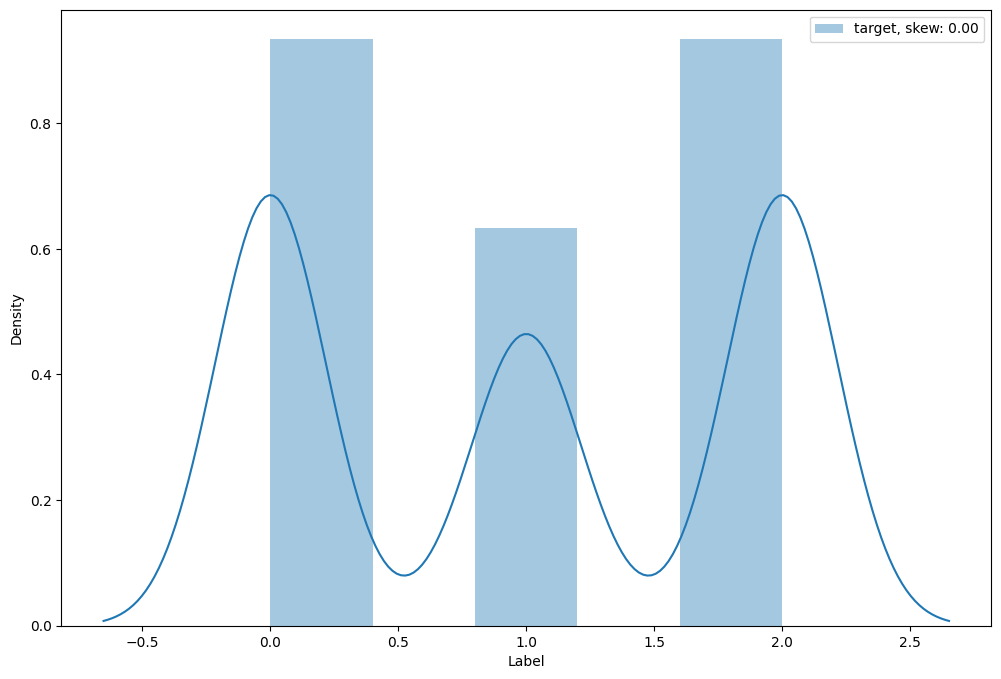

In [181]:
# Visualizing the target variable
plt.figure(figsize=(12,8))
sns.distplot(dataset_label, label=f'target, skew: {dataset_label.skew():.2f}')
plt.legend(loc='best')
plt.show()

In [182]:
dataset_label.value_counts()

,count
Label,
2.0,372
0.0,372
1.0,252


# Ekstraksi Fitur dan Machine Learning

In [183]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.model_selection import train_test_split

In [184]:
train_x, test_x, train_label, test_label = train_test_split(dataset_feature, dataset_label, test_size = 0.3, random_state=42)

In [185]:
test_x

,ProcessedText
832,user user kayake barang harga
970,ikut kisruh pariwisata flores hari2 inti numbe...
96,user user user ok mana
587,user user tai
450,user user pasang foto atm ekonomi bangkit
...,...
7,presiden user terang pers kunjung kerja pasar ...
155,user user user jaga bersih buang sampah tempat...
539,menkominfo user fiber optic indonesia putus fi...
994,tindak perintah presiden user cegah ulang banj...


# load TF-IDF

In [186]:
from sklearn.feature_extraction.text import TfidfVectorizer
Tfidf_Vectorizer = TfidfVectorizer()

# Naive Bayes

In [187]:
from sklearn.naive_bayes import MultinomialNB

In [188]:
from sklearn.pipeline import Pipeline
classifier_nb = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('model', MultinomialNB()),
])

In [189]:
parameters_nb = {
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3), (1, 4)],
    'model__alpha': (0.0001, 0.001, 0.1, 1, 10, 100)
}

In [190]:
classifier_nb = GridSearchCV(classifier_nb, parameters_nb, cv = 3, n_jobs=-1)

In [191]:
classifier_nb.fit(train_x, train_label.ravel())

<ipython-input-191-4a4839e58558>:1: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  classifier_nb.fit(train_x, train_label.ravel())


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('model', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'model__alpha': (0.0001, 0.001, 0.1, 1, 10, 100),
                         'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3),
                                                (1, 4)]})

In [192]:
y_pred_nb_train = classifier_nb.predict(train_x)
accuracy_nb_train = accuracy_score(train_label, y_pred_nb_train)
print("Accuracy Training set: ", accuracy_nb_train)

y_pred_nb_test = classifier_nb.predict(test_x)
accuracy_nb_test = accuracy_score(test_label, y_pred_nb_test)
print("Accuracy Test set: ", accuracy_nb_test)

Accuracy Training set:  0.9483500717360115
Accuracy Test set:  0.5217391304347826


In [193]:
recall_nb_train = recall_score(train_label, y_pred_nb_train, average='weighted')
print("Recall Training set: ", recall_nb_train)

recall_nb_test = recall_score(test_label, y_pred_nb_test, average='weighted')
print("Recall Test set: ", recall_nb_test)

Recall Training set:  0.9483500717360115
Recall Test set:  0.5217391304347826


In [194]:
precision_nb_train = precision_score(train_label, y_pred_nb_train, average='weighted')
print("Precision Training set: ", precision_nb_train)

precision_nb_test = precision_score(test_label, y_pred_nb_test, average='weighted')
print("Precision Test set: ", precision_nb_test)

Precision Training set:  0.9484535782092051
Precision Test set:  0.533803642980486


In [195]:
f1_nb_train = f1_score(train_label, y_pred_nb_train, average='weighted')
print("F1 Training set: ", f1_nb_train)

f1_nb_test = f1_score(test_label, y_pred_nb_test, average='weighted')
print("F1 Test set: ", f1_nb_test)

F1 Training set:  0.9472631719945152
F1 Test set:  0.4778646588962321


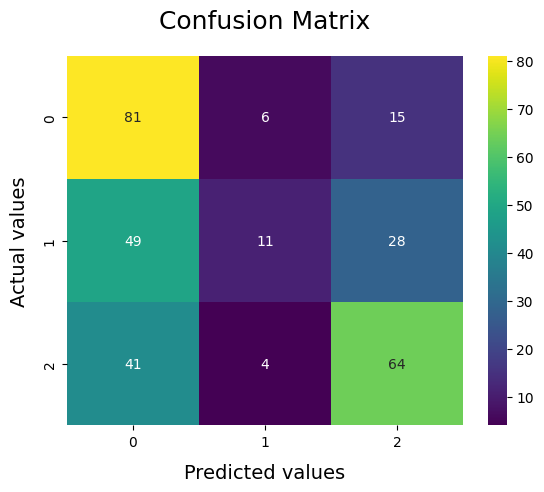

In [196]:
from sklearn.metrics import confusion_matrix
sns.heatmap(confusion_matrix(test_label, y_pred_nb_test), annot=True, cmap = 'viridis', fmt='.0f')
plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)
plt.show()

In [197]:
classifier_nb.best_estimator_

Pipeline(steps=[('tfidf', TfidfVectorizer(ngram_range=(1, 4))),
                ('model', MultinomialNB(alpha=1))])

In [198]:
for param_name in sorted(parameters_nb.keys()):
    print("%s: %r" % (param_name, classifier_nb.best_params_[param_name]))

model__alpha: 1
tfidf__ngram_range: (1, 4)


# KNN

In [199]:
from sklearn.neighbors import KNeighborsClassifier

In [200]:
train_x.dtype

dtype('O')

In [201]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
train_x_encoded = label_encoder.fit_transform(train_x)

In [202]:
test_x_encoded = label_encoder.fit_transform(test_x)

In [203]:
train_x_encoded.dtype

dtype('int64')

In [204]:
train_x_encoded = train_x_encoded.reshape(-1, 1)
# train_label = train_label.reshape(-1, 1)

In [205]:
test_x_encoded = test_x_encoded.reshape(-1, 1)

In [206]:
model = KNeighborsClassifier(n_neighbors=3)
model.fit(train_x_encoded, train_label)

KNeighborsClassifier(n_neighbors=3)

In [207]:
y_pred_knn_train = model.predict(train_x_encoded)
accuracy_knn_train = accuracy_score(train_label, y_pred_knn_train)
print("Accuracy Training set: ", accuracy_knn_train)

y_pred_knn_test = model.predict(test_x_encoded)
accuracy_knn_test = accuracy_score(test_label, y_pred_knn_test)
print("Accuracy Test set: ", accuracy_knn_test)

Accuracy Training set:  0.6958393113342898
Accuracy Test set:  0.3779264214046823


In [208]:
recall_knn_train = recall_score(train_label, y_pred_knn_train, average='weighted')
print("Recall Training set: ", recall_knn_train)

recall_knn_test = recall_score(test_label, y_pred_knn_test, average='weighted')
print("Recall Test set: ", recall_knn_test)

Recall Training set:  0.6958393113342898
Recall Test set:  0.3779264214046823


In [209]:
precision_knn_train = precision_score(train_label, y_pred_knn_train, average='weighted')
print("Precision Training set: ", precision_knn_train)

precision_knn_test = precision_score(test_label, y_pred_knn_test, average='weighted')
print("Precision Test set: ", precision_knn_test)

Precision Training set:  0.7109484632441324
Precision Test set:  0.37491313166475826


In [210]:
f1_knn_train = f1_score(train_label, y_pred_knn_train, average='weighted')
print("F1 Training set: ", f1_knn_train)

f1_knn_test = f1_score(test_label, y_pred_knn_test, average='weighted')
print("F1 Test set: ", f1_knn_test)

F1 Training set:  0.6934318670292741
F1 Test set:  0.36425818380946634


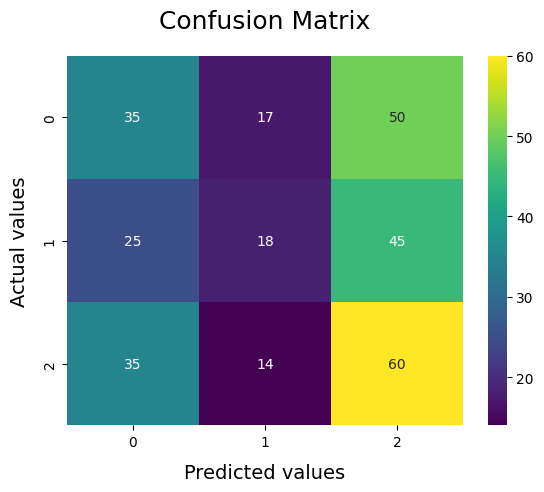

In [211]:
from sklearn.metrics import confusion_matrix
sns.heatmap(confusion_matrix(test_label, y_pred_knn_test), annot=True, cmap = 'viridis', fmt='.0f')
plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)
plt.show()

# Visualisasi

In [212]:
models = [
          ('Naive Bayes Multinomial', accuracy_nb_train, accuracy_nb_test),
          ('KNN', accuracy_knn_train, accuracy_knn_test),
         ]

In [213]:
predict = pd.DataFrame(data = models, columns=['Model', 'Training Accuracy', 'Test Accuracy'])
predict

,Model,Training Accuracy,Test Accuracy
0,Naive Bayes Multinomial,0.948350,0.521739
1,KNN,0.695839,0.377926


In [214]:
models_comparison = [
                        ('Naive Bayes Multinomial', accuracy_nb_test, recall_nb_test, precision_nb_test, f1_nb_test),
                        ('KNN', accuracy_knn_test, recall_knn_test, precision_knn_test, f1_knn_test),
                    ]

In [215]:
comparison = pd.DataFrame(data = models_comparison, columns=['Model', 'Accuracy', 'Recall', 'Precision', 'F1 Weighted'])
comparison

,Model,Accuracy,Recall,Precision,F1 Weighted
0,Naive Bayes Multinomial,0.521739,0.521739,0.533804,0.477865
1,KNN,0.377926,0.377926,0.374913,0.364258


<ipython-input-216-2f10045df05b>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Training Accuracy', y='Model', data = predict, palette='Blues_d', ax = axes[0])
<ipython-input-216-2f10045df05b>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Test Accuracy', y='Model', data = predict, palette='Greens_d', ax = axes[1])


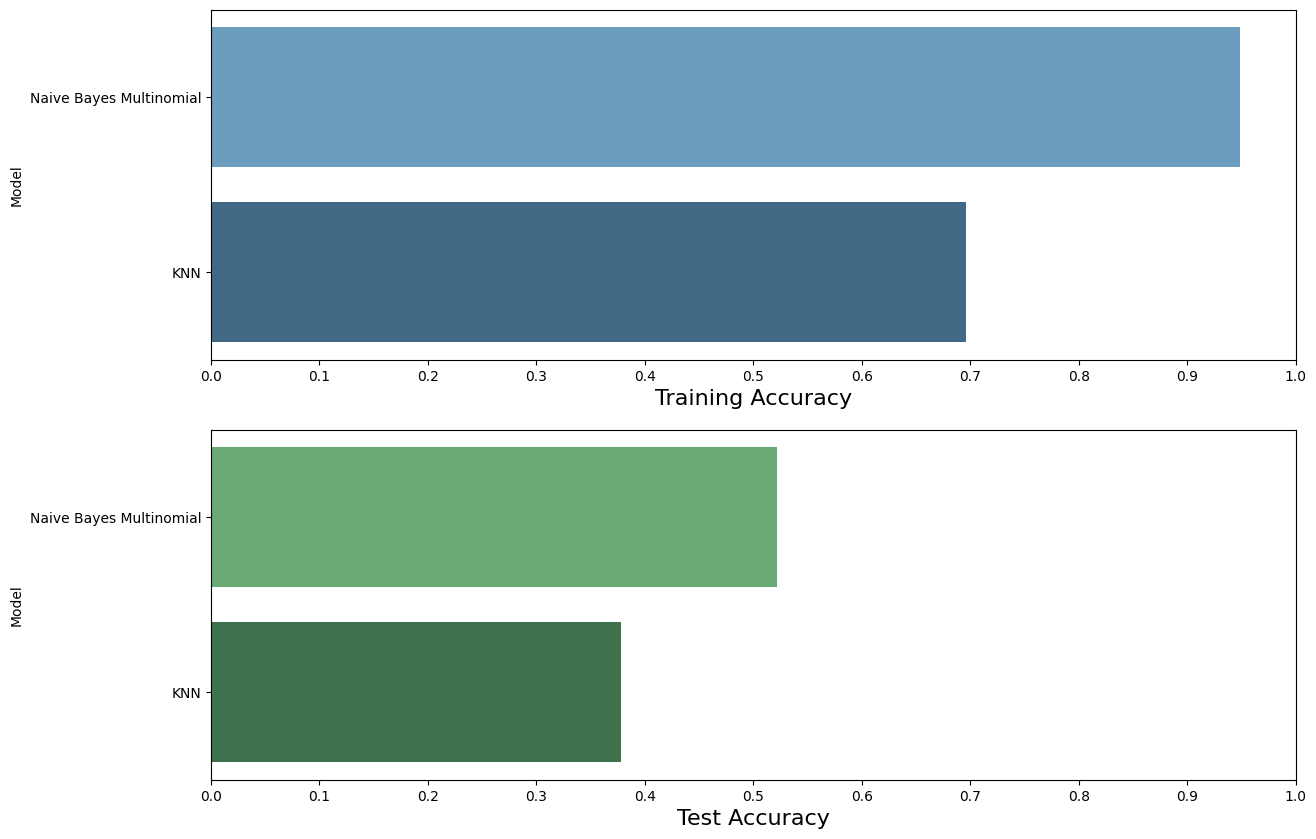

In [216]:
import numpy as np

f, axes = plt.subplots(2,1, figsize=(14,10))

predict.sort_values(by=['Training Accuracy'], ascending=False, inplace=True)

sns.barplot(x='Training Accuracy', y='Model', data = predict, palette='Blues_d', ax = axes[0])
#axes[0].set(xlabel='Region', ylabel='Charges')
axes[0].set_xlabel('Training Accuracy', size=16)
axes[0].set_ylabel('Model')
axes[0].set_xlim(0,1.0)
axes[0].set_xticks(np.arange(0, 1.1, 0.1))

predict.sort_values(by=['Test Accuracy'], ascending=False, inplace=True)

sns.barplot(x='Test Accuracy', y='Model', data = predict, palette='Greens_d', ax = axes[1])
#axes[0].set(xlabel='Region', ylabel='Charges')
axes[1].set_xlabel('Test Accuracy', size=16)
axes[1].set_ylabel('Model')
axes[1].set_xlim(0,1.0)
axes[1].set_xticks(np.arange(0, 1.1, 0.1))

plt.show()

# simpan kedalam joblib

In [217]:
import joblib

In [218]:
# save the model to disk
joblib.dump(classifier_nb.best_estimator_, 'classifier_nb.best_estimator_.sav', compress=1)

['classifier_nb.best_estimator_.sav']